
# Detection Malicious URL Using Google's BERT



A URL consists of the top-level domain, hostname, paths, and port of the web address, as in the following diagram:

In [ ]:
A URL consists of the top-level domain, hostname, paths, and port of the web addresses

In [2]:
!pip install tld

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.8/263.8 kB 5.0 MB/s eta 0:00:00


In [2]:
!pip install transformers

In [9]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
import itertools

from urllib.parse import urlparse

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from tld import get_tld, is_tld

import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D


In [3]:
# Mount the dataset from google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load the dataset 

In [4]:
# load the dataset from the drive into a pandas dataframe
data = pd.read_csv('/content/drive/MyDrive/malicious_dataset.csv')
data2=data.copy() # saves the data on another cell

In [5]:
# clean the dataset 
indexNames = data2[ data2['type'] == 'defacement' ].index

data2.drop(indexNames , inplace=True) # drop the malware and defacement urls

# deleting the malwares
indexNames = data2[ data2['type'] == 'malware' ].index
# Delete these row indexes from dataFrame
data2.drop(indexNames , inplace=True)

## Feature extraction
This stage involves transforming raw text data into numerical feature vectors that can be used as input. The goal of this is to capture the important information in the text data and represent it in a way that can be easily processed by machine learning algorithms. with respect to the proposed research, it generates contextualized embeddings of the URL text, which would then be used as input to a model.

In [6]:
data2 # Contains benign and phishing URLs

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign
...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing
651188,www.gamespot.com/xbox360/action/deadspace/,phishing
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing


In [7]:
# Adds a new column to the data (as numerical value)
data2['url'] = data2['url'].replace('www.', '', regex=True) # removes the 'www.' in all entries and replaces with an empty space
rem = {"Category": {"benign": 0,  "phishing":1}} # represents benign and phishing URLs as 0 and 1 respectively
data2['Category'] = data2['type']
data2 = data2.replace(rem)
data2.head()

,url,type,Category
0,br-icloud.com.br,phishing,1
1,mp3raid.com/music/krizz_kaliko.html,benign,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign,0
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign,0


Text(0, 0.5, 'Number of URL')

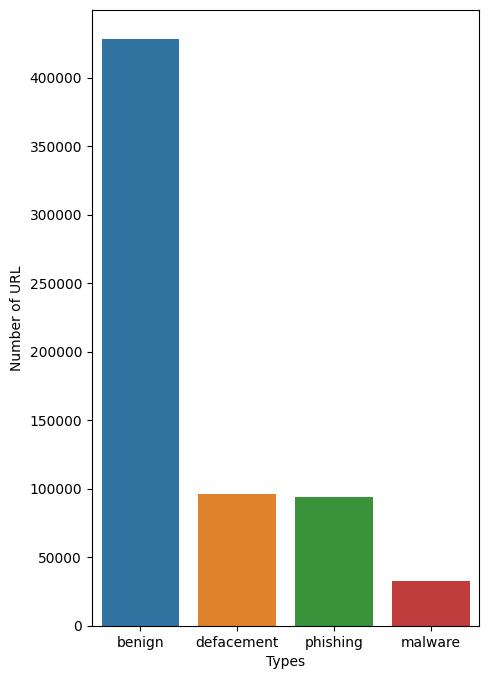

In [112]:
count = data.type.value_counts() # the types and count of URLs in the dataset
count
#  a bar plot with the different types of URLs..
# ...on the x-axis and the number of URLs of each type on the y-axis.
sns.barplot(x=count.index, y=count)
plt.xlabel('Types')
plt.ylabel('Number of URL')

In [8]:
data2.describe #information about the data

<bound method NDFrame.describe of                                                       url      type  Category
0                                        br-icloud.com.br  phishing         1
1                     mp3raid.com/music/krizz_kaliko.html    benign         0
2                         bopsecrets.org/rexroth/cr/1.htm    benign         0
5       http://buzzfil.net/m/show-art/ils-etaient-loin...    benign         0
6           espn.go.com/nba/player/_/id/3457/brandon-rush    benign         0
...                                                   ...       ...       ...
651186            xbox360.ign.com/objects/850/850402.html  phishing         1
651187       games.teamxbox.com/xbox-360/1860/Dead-Space/  phishing         1
651188             gamespot.com/xbox360/action/deadspace/  phishing         1
651189      en.wikipedia.org/wiki/Dead_Space_(video_game)  phishing         1
651190              angelfire.com/goth/devilmaycrytonite/  phishing         1

[522214 rows x 3 columns]>

In [9]:
# adds a new column to the data called url_len. It calculates the 
#...length of each URL in the url column by applying a lambda function
data2['url_len'] = data2['url'].apply(lambda x: len(str(x)))

In [10]:
def process_tld(url):
    try:
# Extract the top level domain (TLD) 
        res = get_tld(url, as_object = True, fail_silently=False,fix_protocol=True)
        pri_domain= res.parsed_url.netloc
    except :
        pri_domain= None
    return pri_domain
# adds a new column to the data called 'domain' and takes in the extracted top-level domains
data2['domain'] = data2['url'].apply(lambda i: process_tld(i)) 

In [11]:
# counts the number of times the character 'a' (which takes on each value in 
#...feature during each iteration of the loop) appears in each URL
feature = ['@','?','-','=','.','#','%','+','$','!','*',',','//']
for a in feature:
    data2[a] = data2['url'].apply(lambda i: i.count(a))

In [12]:
# this method takes a URL as input and returns a binary value (1 or 0)
#...indicating whether the URL contains an abnormal pattern.
def abnormal_url(url):
    hostname = urlparse(url).hostname
   ## print(hostname)
    hostname = str(hostname)
   # print(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0

data2['abnormal_url'] = data2['url'].apply(lambda i: abnormal_url(i))

In [13]:
def httpSecure(url):
    htp = urlparse(url).scheme #It supports the following URL schemes: file , ftp , gopher , hdl , 
                               #http , https ... from urllib.parse
    match = str(htp)
    if match=='https':
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0
data2['https'] = data2['url'].apply(lambda i: httpSecure(i))

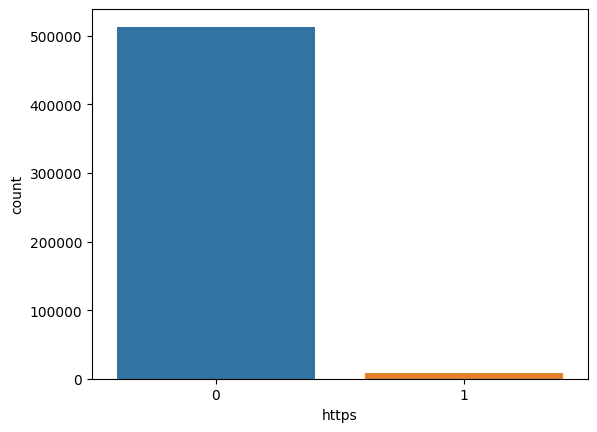

In [14]:
sns.countplot(x='https', data=data2);

well, unbalanced dataset ! 


In [15]:
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits
data2['digits']= data2['url'].apply(lambda i: digit_count(i))

In [16]:
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters


In [17]:
data2['letters']= data2['url'].apply(lambda i: letter_count(i))

In [18]:
def Shortining_Service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0
    
data2['Shortining_Service'] = data2['url'].apply(lambda x: Shortining_Service(x))

In [19]:
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4 with port
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
        '([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
        '((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)', url)  # Ipv6
    if match:
        return 1
    else:
        return 0
data2['having_ip_address'] = data2['url'].apply(lambda i: having_ip_address(i))

## Model development and Training

In [12]:
X = data2.drop(['url','type','Category','domain'],axis=1) # Independent variables
y = data2['Category'] # Dependent variable

NameError: name 'data2' is not defined

In [98]:
# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

## LSTM model

In [25]:
model = Sequential()
model.add(Embedding(5000, 128, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(256, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


In [54]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_history = model.fit(X_train, y_train, epochs=10, batch_size=1024, validation_data=(X_test, y_test))

Epoch 1/10
408/408 [==============================] - 690s 2s/step - loss: 0.2283 - accuracy: 0.9102 - val_loss: 0.2274 - val_accuracy: 0.9106
Epoch 2/10
408/408 [==============================] - 682s 2s/step - loss: 0.2267 - accuracy: 0.9113 - val_loss: 0.2267 - val_accuracy: 0.9110
Epoch 3/10
408/408 [==============================] - 676s 2s/step - loss: 0.2259 - accuracy: 0.9113 - val_loss: 0.2258 - val_accuracy: 0.9115
Epoch 4/10
408/408 [==============================] - 677s 2s/step - loss: 0.2249 - accuracy: 0.9119 - val_loss: 0.2264 - val_accuracy: 0.9110
Epoch 5/10
408/408 [==============================] - 688s 2s/step - loss: 0.2236 - accuracy: 0.9122 - val_loss: 0.2252 - val_accuracy: 0.9114
Epoch 6/10
408/408 [==============================] - 681s 2s/step - loss: 0.2228 - accuracy: 0.9125 - val_loss: 0.2243 - val_accuracy: 0.9120
Epoch 7/10
408/408 [==============================] - 669s 2s/step - loss: 0.2221 - accuracy: 0.9126 - val_loss: 0.2240 - val_accuracy: 0.9120

In [46]:
accuracy = model.evaluate(X_test, y_test)



3264/3264 [==============================] - 133s 41ms/step - loss: 0.2292 - accuracy: 0.9101
[0.22923777997493744, 0.9101423621177673]


### Evaluation

In [56]:
def modelLoss(history,title):
    fig = plt.figure(dpi=50, figsize = (20,15))
    ax1 = fig.add_subplot(221)
    
    ax1.plot(history.history['loss'], label='train_loss')
    ax1.plot(history.history['val_loss'], label = 'val_loss')
    ax1.legend(loc='center right')

    fig.text(0.3, 0.4, 'epoch', ha='center', va='center')
    fig.text(0.06, 0.7, 'loss', ha='center', va='center', rotation='vertical')
    
    ax1.set_title(title)
    plt.show()

In [60]:
def modelAccuracy(history,title):
    fig = plt.figure(dpi=150, figsize = (10,7))
    ax1 = fig.add_subplot(221)

    ax1.plot(history.history['accuracy'], label='train_accuracy')
    ax1.plot(history.history['val_accuracy'], label = 'val_accuracy')
    ax1.legend(loc='center right')

    fig.text(0.3, 0.4, 'epoch', ha='center', va='center')
    fig.text(0.06, 0.7, 'accuracy', ha='center', va='center', rotation='vertical')

    ax1.set_title(title)

    plt.show()

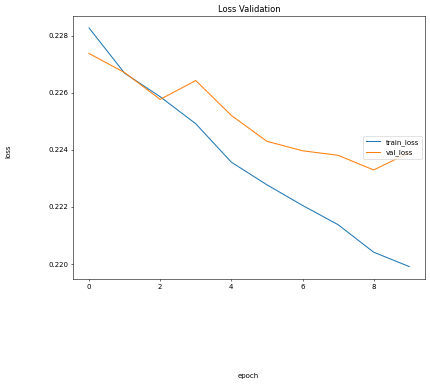

In [61]:
modelLoss(model_history,"Loss Validation")

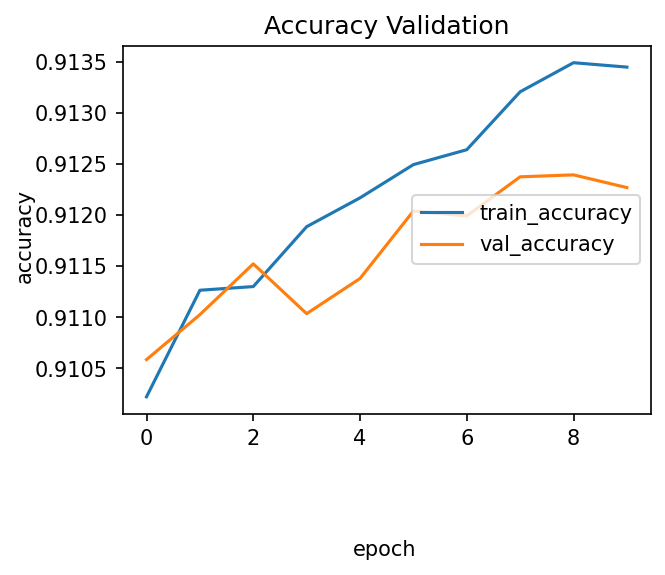

In [62]:
modelAccuracy(model_history,"Accuracy Validation")

### Classification report

In [63]:
#confusion matrix plot function 
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `noramlize=True`
    '''
    plt.rcParams["figure.figsize"] = (5,8)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)

    #plot.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('confusion matrix, without Normalized')
    
    print(cm)
    
    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
                horizontalalignment='center',
                color='white' if cm[i,j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [105]:
pred_custom = model.predict(x = X_test, verbose=1)
pred_custom = pred_custom > 0.5

3264/3264 [==============================] - 125s 38ms/step


In [101]:
print(pred_custom.shape)

(104443,)


In [106]:
y_test[:5]

277231    0
470170    0
164387    0
460166    0
621381    1
Name: Category, dtype: int64

In [107]:
cm = confusion_matrix(y_test, pred_custom)

In [108]:
cm

array([[84373,  1253],
       [ 7910, 10907]])

confusion matrix, without Normalized
[[84373  1253]
 [ 7910 10907]]


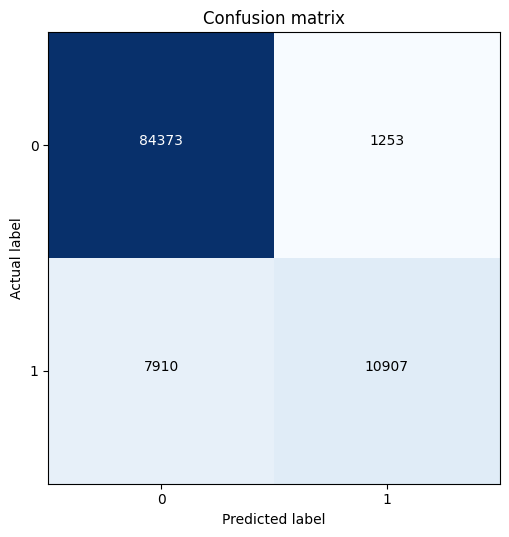

In [109]:
plot_confusion_matrix(cm, classes=['0', '1'],
                      title='Confusion matrix')

In [110]:
print(classification_report(y_true = y_test,y_pred = pred_custom,target_names = ['0','1']))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95     85626
           1       0.90      0.58      0.70     18817

    accuracy                           0.91    104443
   macro avg       0.91      0.78      0.83    104443
weighted avg       0.91      0.91      0.90    104443



### BERT Model

In [4]:
import transformers
from transformers import BertTokenizer, TFBertForSequenceClassification

In [7]:
# Define the tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

# Define the maximum sequence length
max_length = 128

# Tokenize the text data
def tokenize_text(text):
    return tokenizer.encode_plus(text, 
                                  add_special_tokens=True, 
                                  max_length=max_length, 
                                  padding='max_length', 
                                  truncation=True, 
                                  return_attention_mask=True,
                                  return_tensors='tf')

In [10]:


# Load the pre-trained BERT model
model = transformers.TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:

model_history2 = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))

NameError: name 'X_train' is not defined